# Support Vector Machines Lab

In [123]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score,cross_val_predict
from sklearn import feature_selection
from sklearn.decomposition import PCA
%matplotlib inline

In this lab we will explore several datasets with SVMs. The assets folder contains several datasets (in order of complexity):

1. Breast cancer
- Spambase
- Car evaluation
- Mushroom

For each of these a `.names` file is provided with details on the origin of data.

# Exercise 1: Breast Cancer



## 1.a: Load the Data
Use `pandas.read_csv` to load the data and assess the following:
- Are there any missing values? (how are they encoded? do we impute them?)
- Are the features categorical or numerical?
- Are the values normalized?
- How many classes are there in the target?

Perform what's necessary to get to a point where you have a feature matrix `X` and a target vector `y`, both with only numerical entries.

In [38]:
df=pd.read_csv("../../assets/datasets/breast_cancer.csv")
df.dtypes
#Data missing in Bare_Nuclei, will drop missing data points
df=df[df['Bare_Nuclei']!='?']
df['Bare_Nuclei']=df['Bare_Nuclei'].astype(int)
X=df.iloc[:,1:-1]
y=df.iloc[:,-1]

In [269]:
df=pd.read_csv("../../assets/datasets/mushroom.csv")
df.dtypes

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises?                    object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [37]:
df["Class"].value_counts()

2    444
4    239
Name: Class, dtype: int64

In [31]:
df.head()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


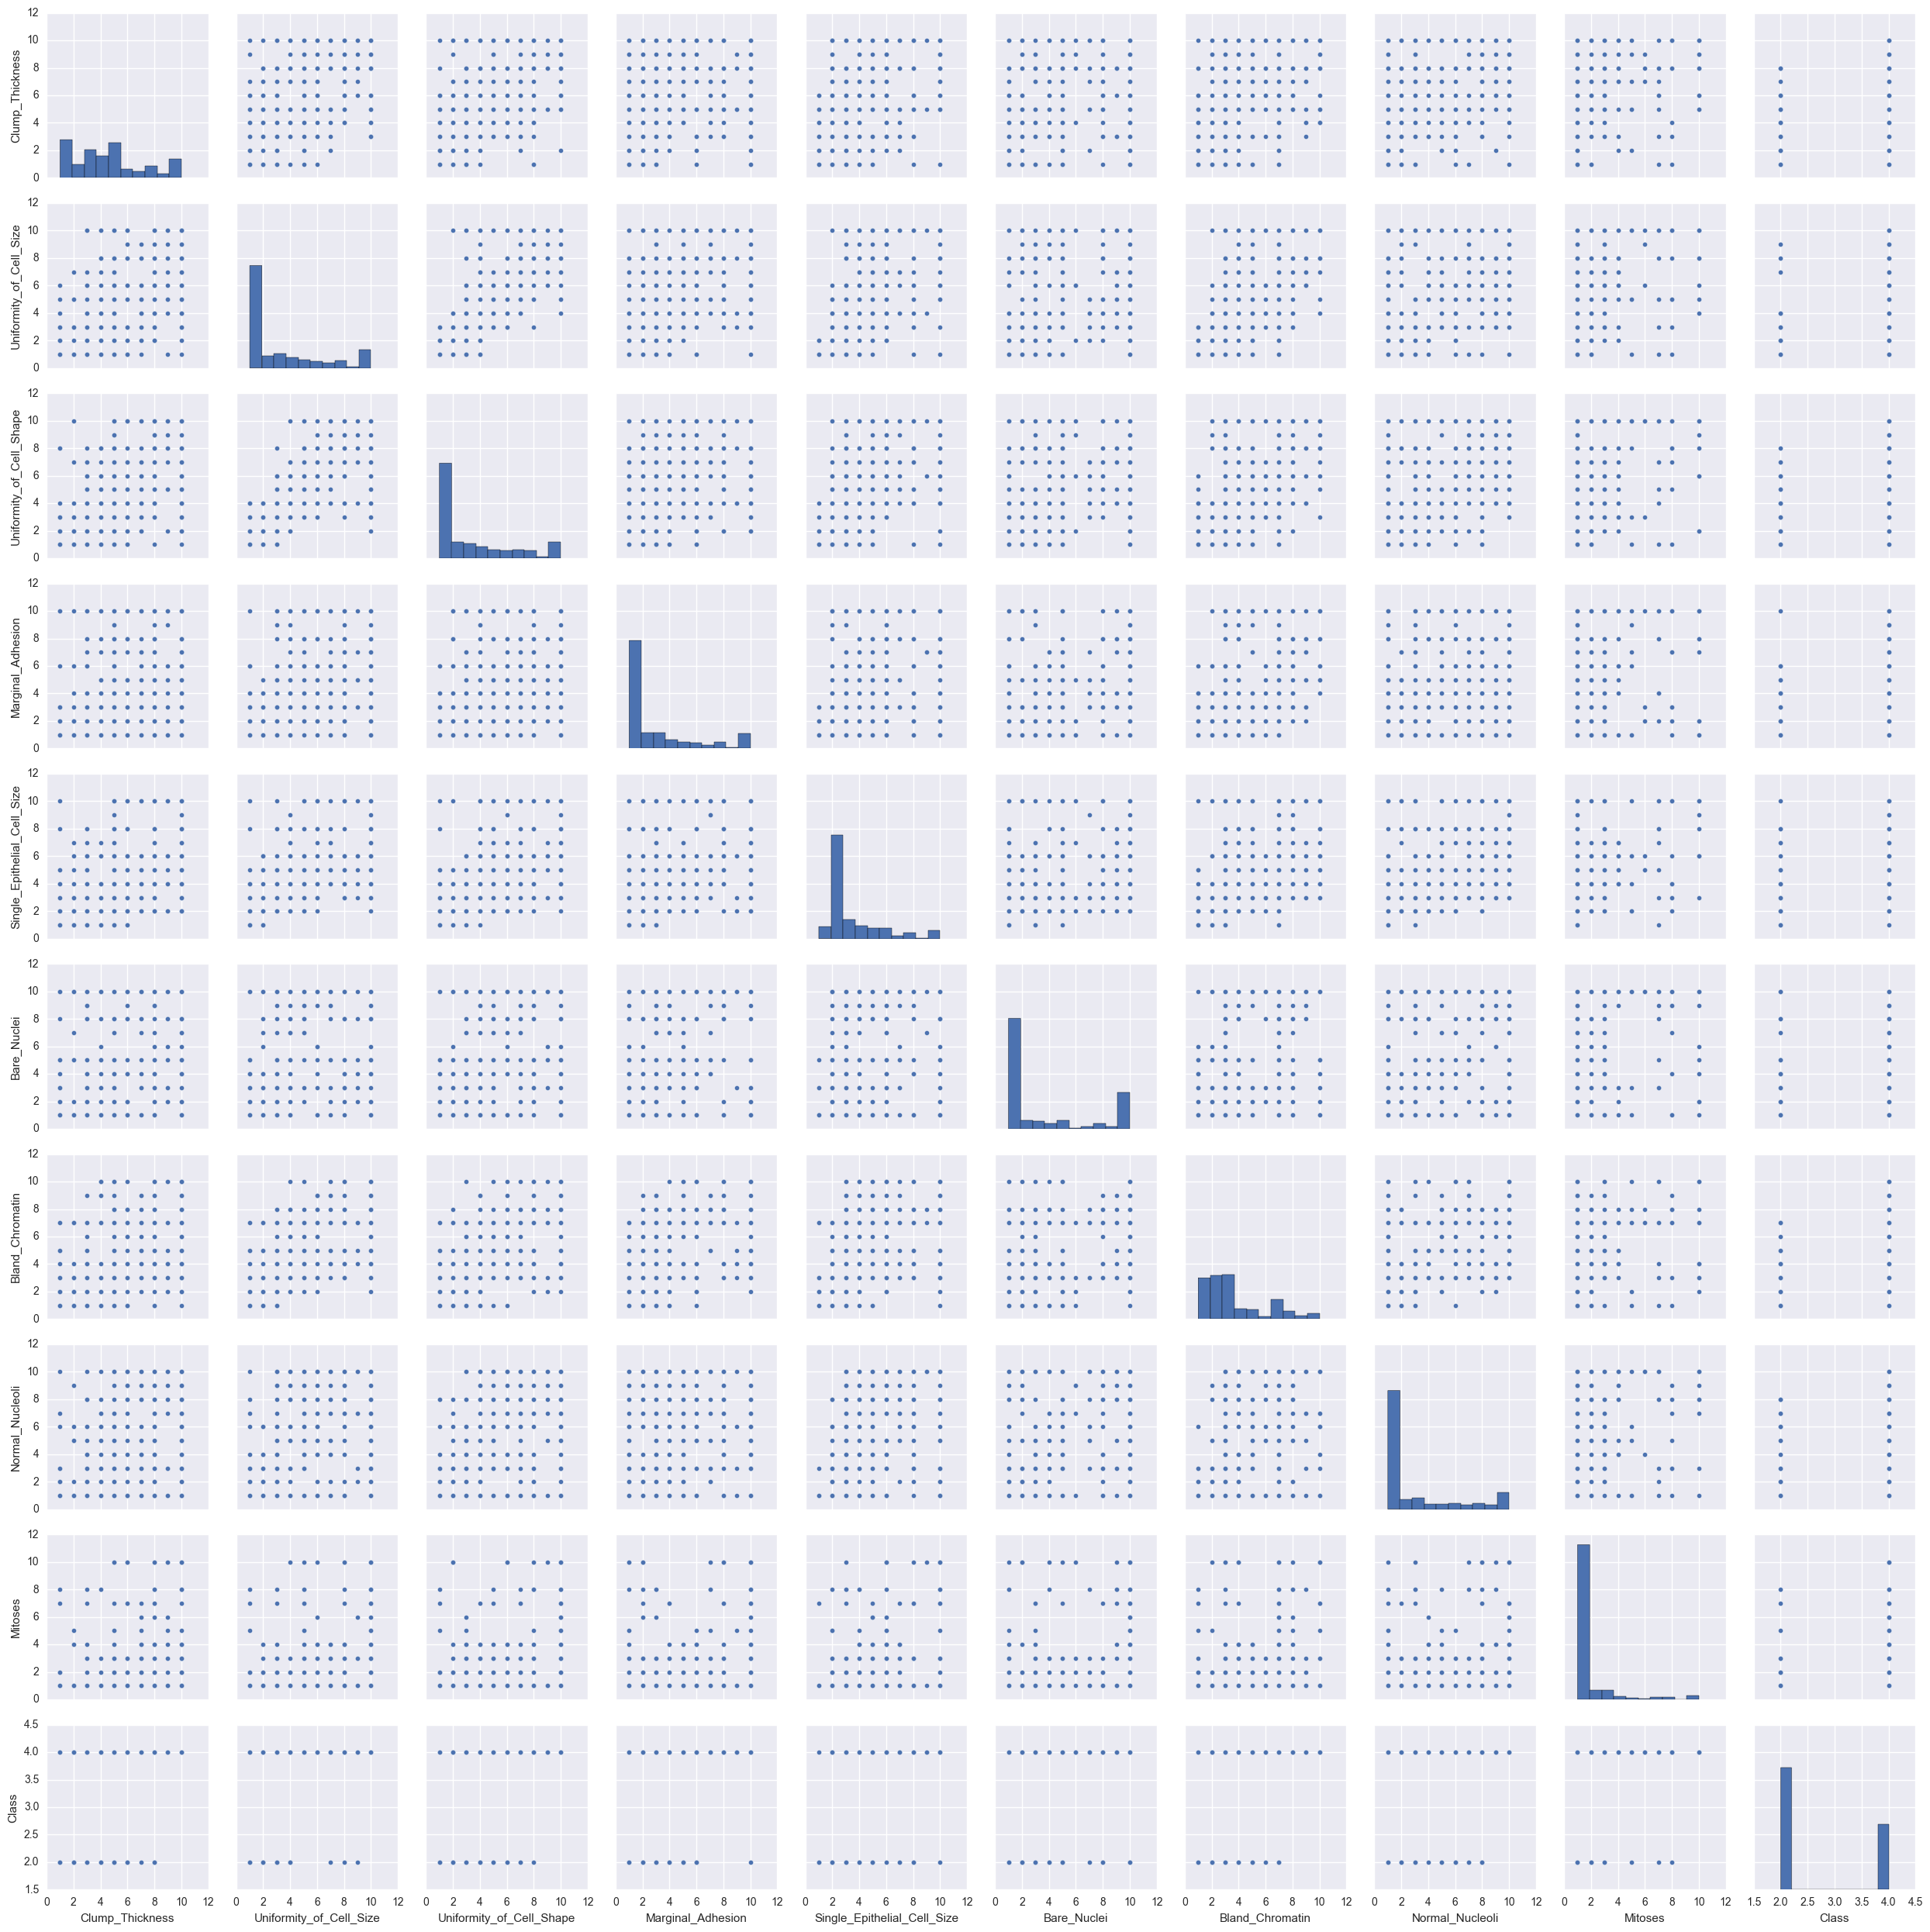

In [32]:
sns.pairplot(df.iloc[:,1:])

Data is not normalized

In [53]:
X0=X
X1=preprocessing.Normalizer().fit_transform(X)
X2=preprocessing.MinMaxScaler().fit_transform(X)
X3=preprocessing.RobustScaler().fit_transform(X)

/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


## 1.b: Model Building

- What's the baseline for the accuracy?
- Initialize and train a linear svm. What's the average accuracy score with a 3-fold cross validation?
- Repeat using an rbf classifier. Compare the scores. Which one is better?
- Are your features normalized? if not, try normalizing and repeat the test. Does the score improve?
- What's the best model?
- Print a confusion matrix and classification report for your best model using:
        train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

**Check** to decide which model is best, look at the average cross validation score. Are the scores significantly different from one another?

In [77]:
y.value_counts()

2    444
4    239
Name: Class, dtype: int64

In [140]:
for data in [X0,X1,X2,X3]:
    print "Linear:",np.mean(cross_val_score(SVC(kernel='linear'),data,y,cv=15))
    print "Rbf:  :",np.mean(cross_val_score(SVC(kernel='rbf'),data,y,cv=15))
    print 


x_train,x_test,y_train,y_test=train_test_split(X2,y)
clf=SVC().fit(x_train,y_train)
pred=clf.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,pred),columns=["Clear","OH SHIT"],index=["Clear","OH SHIT"])
#There are more false positives

Linear: 0.966473429952
Rbf:  : 0.957809983897

Linear: 0.877354706485
Rbf:  : 0.878868394086

Linear: 0.967922705314
Rbf:  : 0.967954911433

Linear: 0.967922705314
Rbf:  : 0.965022690675



,Clear,OH SHIT
Clear,100,1
OH SHIT,4,66


**Check:** Are there more false positives or false negatives? Is this good or bad?

## 1.c: Feature Selection

Use any of the strategies offered by `sklearn` to select the most important features.

Repeat the cross validation with only those 5 features. Does the score change?

In [186]:
pca=PCA().fit(X2)
print np.cumsum(pca.explained_variance_ratio_)
pca=PCA(n_components=3).fit_transform(X2)

[ 0.69050756  0.76245823  0.82301744  0.86743756  0.9064427   0.94088169
  0.96617646  0.98864155  1.        ]


In [212]:
X_new = feature_selection.SelectKBest(k=4).fit_transform(X2, y)

In [216]:
x_train,x_test,y_train,y_test=train_test_split(X_new,y)
clf=SVC().fit(x_train,y_train)
pred=clf.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,pred),columns=["Clear","OH SHIT"],index=["Clear","OH SHIT"])

,Clear,OH SHIT
Clear,99,4
OH SHIT,5,63


## 1.d: Learning Curves

Learning curves are useful to study the behavior of training and test errors as a function of the number of datapoints available.

- Plot learning curves for train sizes between 10% and 100% (use StratifiedKFold with 5 folds as cross validation)
- What can you say about the dataset? do you need more data or do you need a better model?

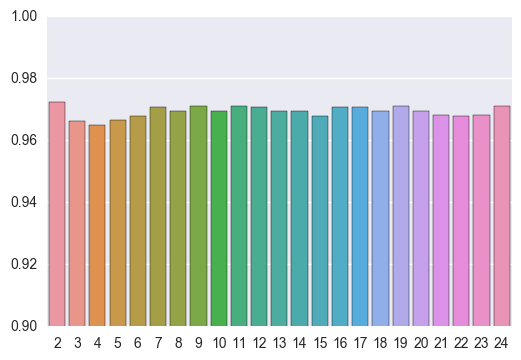

In [237]:
scores=[]
ranges=[]
max_range=25
for i in range(2,max_range):
    scores.append(np.mean(cross_val_score(SVC(),X2,y,cv=i)))
    ranges.append(i)
    plt.ylim(0.9,1.0)
sns.barplot(ranges,scores)
plt.show()

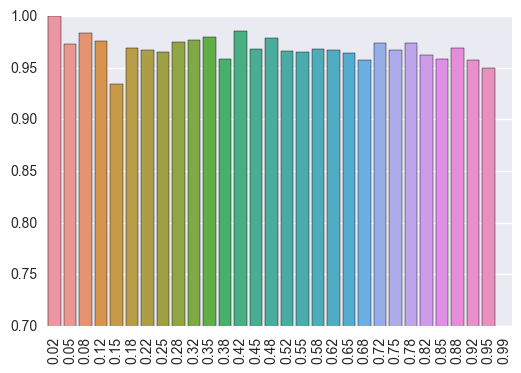

In [266]:
scores=[]
ranges=[]
max_range=30
for i in np.linspace(.02,0.99,max_range):
    x_train,x_test,y_train,y_test=train_test_split(X2,y,test_size=i)
    clf=SVC().fit(x_train,y_train)
    scores.append(clf.score(x_test,y_test))
    ranges.append(float(str(i)[:4]))
    plt.ylim(0.7,1.0)
sns.barplot(ranges,scores)
plt.xticks(rotation=90)
plt.show()

##  1.e: Grid Ssearch

Use the grid_search function to explore different kernels and values for the C parameter.

- Can you improve on your best previous score?
- Print the best parameters and the best score

# Exercise 2
Now that you've completed steps 1.a through 1.e it's time to tackle some harder datasets. But before we do that, let's encapsulate a few things into functions so that it's easier to repeat the analysis.

## 2.a: Cross Validation
Implement a function `do_cv(model, X, y, cv)` that does the following:
- Calculates the cross validation scores
- Prints the model
- Prints and returns the mean and the standard deviation of the cross validation scores

> Answer: see above

## 2.b: Confusion Matrix and Classification report
Implement a function `do_cm_cr(model, X, y, names)` that automates the following:
- Split the data using `train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)`
- Fit the model
- Prints confusion matrix and classification report in a nice format

**Hint:** names is the list of target classes

> Answer: see above

## 2.c: Learning Curves
Implement a function `do_learning_curve(model, X, y, sizes)` that automates drawing the learning curves:
- Allow for sizes input
- Use 5-fold StratifiedKFold cross validation

> Answer: see above

## 2.d: Grid Search
Implement a function `do_grid_search(model, parameters)` that automates the grid search by doing:
- Calculate grid search
- Print best parameters
- Print best score
- Return best estimator


> Answer: see above

# Exercise 3
Using the functions above, analyze the Spambase dataset.

Notice that now you have many more features. Focus your attention on step C => feature selection

- Load the data and get to X, y
- Select the 15 best features
- Perform grid search to determine best model
- Display learning curves

# Exercise 4
Repeat steps 1.a - 1.e for the car dataset. Notice that now features are categorical, not numerical.
- Find a suitable way to encode them
- How does this change our modeling strategy?

Also notice that the target variable `acceptability` has 4 classes. How do we encode them?


# Bonus
Repeat steps 1.a - 1.e for the mushroom dataset. Notice that now features are categorical, not numerical. This dataset is quite large.
- How does this change our modeling strategy?
- Can we use feature selection to improve this?
